In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\train\\',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\validation\\',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [4]:
import efficientnet.tfkeras as efn

In [3]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.00001
        return lr
    elif epoch<=30:
        lr=0.00001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [6]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
    
def f1score(y_true, y_pred):
    
    # Update state and get precision/recall values
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    p = precision.result()
    r = recall.result()
    
    # Compute F1-Score
    f1 = 2 * (p * r) / (p + r + tf.keras.backend.epsilon())  # Avoid division by zero
    return f1

In [7]:
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import efficientnet.tfkeras as efn

input_layer = Input(shape=(224, 224, 3))

base_model = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

for layer in base_model.layers:
    layer.trainable = True

x = base_model(input_layer)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(5, activation='softmax')(x)

retinopathy_model = Model(inputs=input_layer, outputs=output_layer)

retinopathy_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy",Precision(), Recall(), f1score])
retinopathy_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, 7, 7, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,838,049 (18.46 MB)

 Trainable params: 4,796,033 (18.30 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history=retinopathy_model.fit(train_data,validation_data = valid_data,callbacks=[early_stopping,lr_scheduler],epochs=100,verbose=1)

c:\Users\santhosh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.6738 - f1score: 0.5179 - loss: 0.9176 - precision_1: 0.7862 - recall_1: 0.5202 - val_accuracy: 0.5404 - val_f1score: 0.6702 - val_loss: 1.9723 - val_precision_1: 0.5453 - val_recall_1: 0.5267 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7578 - f1score: 0.6711 - loss: 0.6506 - precision_1: 0.8146 - recall_1: 0.6917 - val_accuracy: 0.5363 - val_f1score: 0.6864 - val_loss: 1.4506 - val_precision_1: 0.5923 - val_recall_1: 0.4651 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7751 - f1score: 0.6885 - loss: 0.5635 - precision_1: 0.8364 - recall_1: 0.7269 - val_accuracy: 0.5034 - val_f1score: 0.6991 - val_loss: 7.1842 - val_precision_1: 0.5041 - val_recall_1: 0.4993 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8018 - f1score: 0.6983 - loss: 0.5374 - precision_1: 0.8383 - recall_1: 0.7462 - val_acc

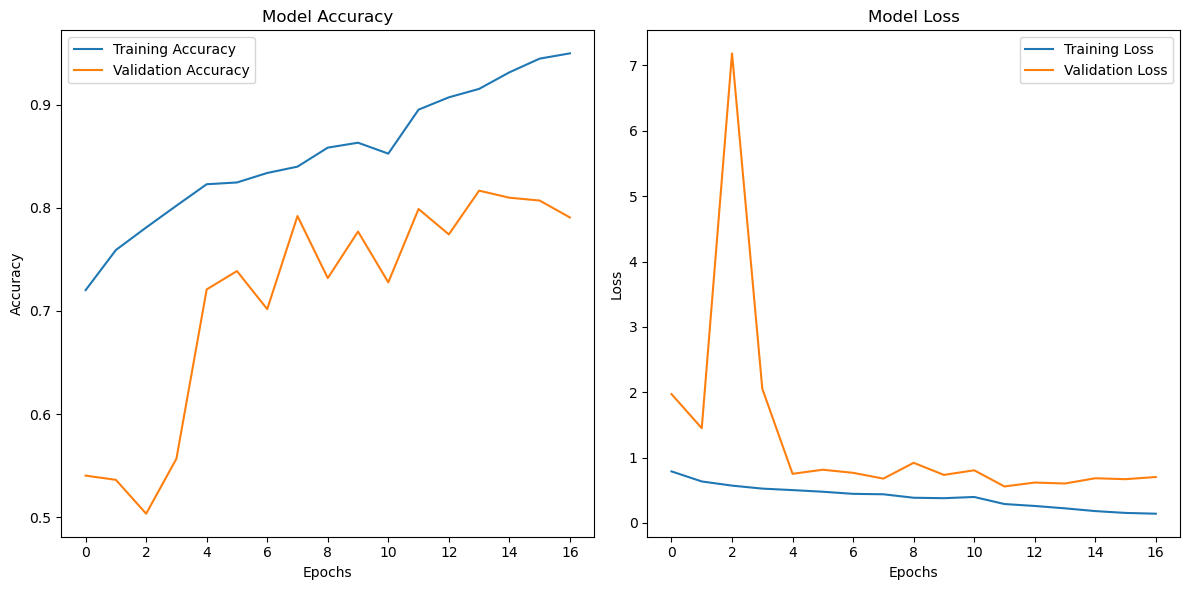

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
print(history.history.keys())

dict_keys(['accuracy', 'f1score', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_f1score', 'val_loss', 'val_precision_1', 'val_recall_1', 'learning_rate'])


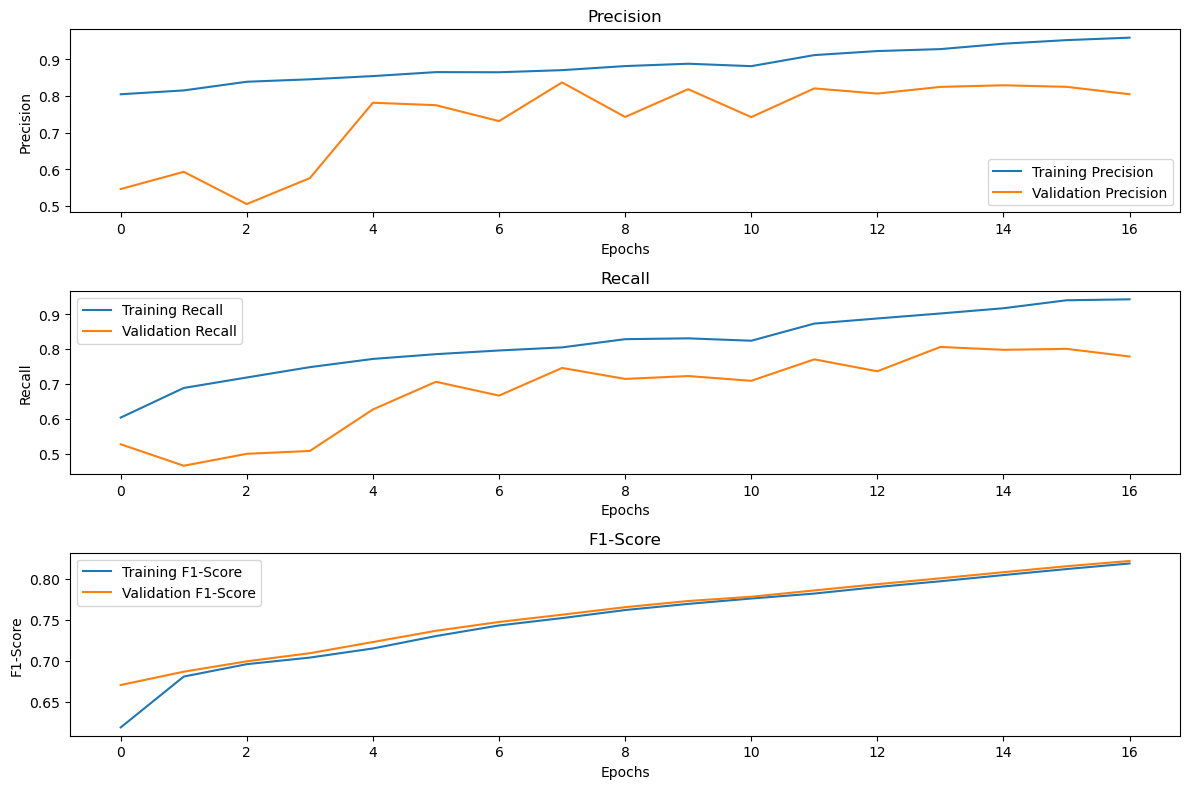

In [11]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(12, 8))

# Precision
plt.subplot(3, 1, 1)
plt.plot(history.history['precision_1'], label='Training Precision')
plt.plot(history.history['val_precision_1'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3, 1, 2)
plt.plot(history.history['recall_1'], label='Training Recall')
plt.plot(history.history['val_recall_1'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# F1-Score
plt.subplot(3, 1, 3)
plt.plot(history.history['f1score'], label='Training F1-Score')
plt.plot(history.history['val_f1score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
test_generator =datagen.flow_from_directory(
    directory=r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
result=retinopathy_model.evaluate(test_generator)

Found 3662 images belonging to 5 classes.
115/115 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.8966 - f1score: 0.8224 - loss: 0.3088 - precision_1: 0.9093 - recall_1: 0.8714


In [13]:
y_pred = np.argmax(retinopathy_model.predict(test_generator), axis=-1) 
y_true = test_generator.classes 

correct_predictions = np.sum(y_pred == y_true)
total_samples = len(y_true)

print(f"Number of correctly classified samples: {correct_predictions} out of {total_samples}")
print(f"Accuracy (in numbers): {correct_predictions}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 48s 401ms/step
Number of correctly classified samples: 3314 out of 3662
Accuracy (in numbers): 3314


In [14]:
accuracy = result[1] 
precision = precision_score(y_true, y_pred, average='weighted') 
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
loss=result[0]


print(f"Model accuracy: {accuracy * 100:.2f}%")
print(f"Model loss: {loss * 100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

Model accuracy: 90.91%
Model loss: 25.79%
Precision: 90.91%
Recall: 90.50%
F1-Score: 90.40%


In [15]:
import cv2

def predict_new(path):
    img = cv2.imread(path)
    predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=retinopathy_model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)
    
    print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted: Severe


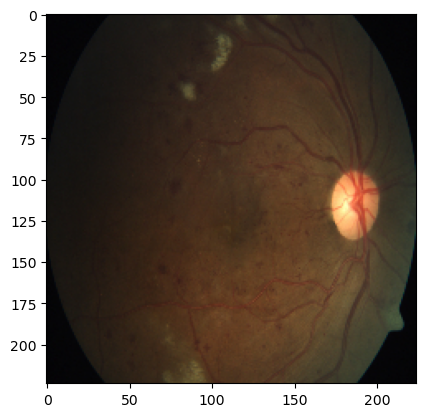

In [27]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train\Severe\3f49f8d100e9.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted: Proliferate_DR


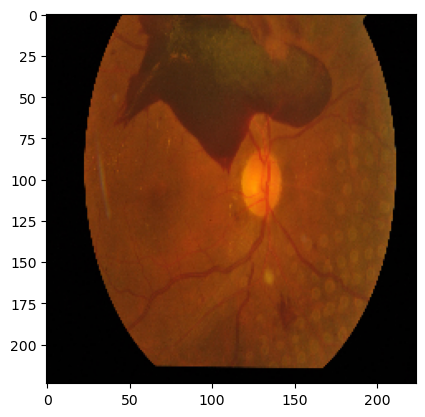

In [25]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\train\Proliferate_DR\0e0fc1d9810c.png')

In [22]:
retinopathy_model.save('combinedmodel.h5')  
